In [596]:
import Nets
using CoordinateTransformations
using ForwardDiff
using MLDataPattern
using Plots; pyplot()
using ProgressMeter

```
Scale a dataset consisting of state inputs and control+sensitivity outputs. For example, let's say our true function is:

    y1 = 2x1 + x2 + 1
    y2 = x1 + 4x2 - 3

We can put in some input data and see what we get:

    x         y
--------------------
[-1, -1]     [-2, -8]
[0, 0]       [1, -3]
[1, 1]       [4, 2]

For our controls application, we also track the desired sensitivity of
the network (the partial derivatives of y_i w.r.t. x_j. Let's write those
sensitivities into our dataset by adding a second dimension:

    x         y
--------------------
[-1, -1]     [-2  2  1
              -8  1  4]
[0, 0]       [1   2  1
              -3  1  4]
[1, 1]       [4   2  1
              2   1  4]

We can scale the *rows* of y however we want, but we can't scale individual elements. That's because we have to maintain the fact that columns 2 and 3 are actually the jacobian of column 1 w.r.t. the input. 

Let's scale the rows of y so that they're between -1 and 1

    x         y .* [1/4, 1/8]
--------------------
[-1, -1]    [-1/2 1/2  1/4
             -1   1/8  1/2]
[0, 0]      [1/4  1/2  1/4
             -3/8 1/8  1/2]
[1, 1]      [1    1/2  1/4
             1/4  1/8  1/2

v1 = 1/2 x1 + 1/4 x2 + 1/4
v2 = 1/8 x1 + 1/2 x2 - 3/8

But now our gradients are only in the range [0, 1/2]. We'd really like to 
rescale them up to [-1, 1]. We can't apply an offset to the gradients, but we can at least scale the individual components by replacing x with a scaled version. 

  x .* [1/2, 1/2]  y .* [1/4, 1/8]
----------------------------------
[-1/2, -1/2]       [-1/2  1    1/2
                    -1    1/4  1]
[0, 0]             [1/4   1    1/2
                    -3/8  1/4  1]
[1/2, 1/2]         [1     1    1/2
                    1/4   1/4  1]

Let's check the function that we're learning now:

v1 = u1 + 1/2 u2 + 1/4
v2 = 1/4 u1 + u2 - 3/8

Now we have a nice function with outputs and gradients which are within [-1, 1]. We can apply the two transforms above to our training and test data and then try to learn v(u). 

When we actually want to deploy our network, we need the original, un-transformed outputs. To do that, we want to:

* take x0
* apply the x -> u transformation (multiply by [1/2, 1/2])
* run the network to get v
* apply the inverse of the y -> v transformation (multiply by [4, 8])

Let's verify that by hand:

x = [-2, -2]
apply x -> u to get u = [-1, -1]
run the network to get v = [-1.25, -1.625]
apply the inverse of y -> v to get [-5, -13]

Expected result is [-5, -13]. It works!
```

Let's actually try putting this through the pipeline:

In [597]:
reload("Nets")

In [598]:
f(x) = [2 * x[1] + x[2] + 1, x[1] + 4 * x[2] - 3]

X = [randn(2) for i in 1:100]
Y = [hcat(f(x), ForwardDiff.jacobian(f, x)) for x in X];

data = collect(zip(X, Y))
train_data, test_data = splitobs(data, 0.1);

train_data_scaled, x_to_u, v_to_y = Nets.rescale(train_data)
for (x, yJ) in train_data
    y = yJ[:, 1]
    J = yJ[:, 2:end]
    @assert y ≈ f(x)
    @assert J ≈ ForwardDiff.jacobian(f, x)
end

u_to_x = inv(x_to_u)
y_to_v = inv(v_to_y)

for (u, vJ) in train_data_scaled
    v = vJ[:, 1]
    J = vJ[:, 2:end]
    @assert v |> v_to_y ≈ u |> u_to_x |> f
    @assert J ≈ ForwardDiff.jacobian(u -> u |> u_to_x |> f |> y_to_v, u)
    @assert maximum(abs, J) ≈ 1.0
end

In [599]:
widths = [2, 2]

function sensitive_loss(λ)
    q = [1.0-λ λ λ]
    (params, x, y) -> sum(abs2, q .* (Nets.predict_sensitivity(Nets.Net(Nets.Params(widths, params)), x) .- y))
end

sensitive_loss (generic function with 1 method)

In [600]:
start_params = randn(Nets.Params{Float64}, widths).data;
nepoch = 100;

mean((xy->begin  # In[601], line 8:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 157.71005944466054


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


mean((xy->begin  # In[601], line 15:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.10057496267373642



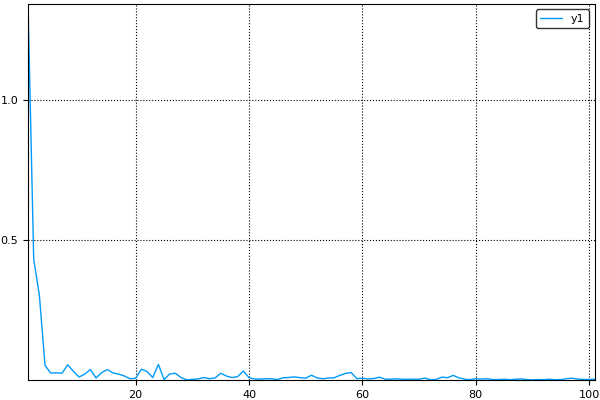

In [601]:
params = copy(start_params)
net = Nets.Net(Nets.Params(widths, params), x_to_u, v_to_y)

train_loss = sensitive_loss(0.0)
validate_loss = sensitive_loss(0.0)
losses = [mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled)]

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

@showprogress for i in 1:nepoch
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.1 * 0.99^i, batch_size=1))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses)

mean((xy->begin  # In[602], line 8:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 157.71005944466054


Progress:  86%|███████████████████████████████████      |  ETA: 0:00:00

mean((xy->begin  # In[602], line 15:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.07156635774992465


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00



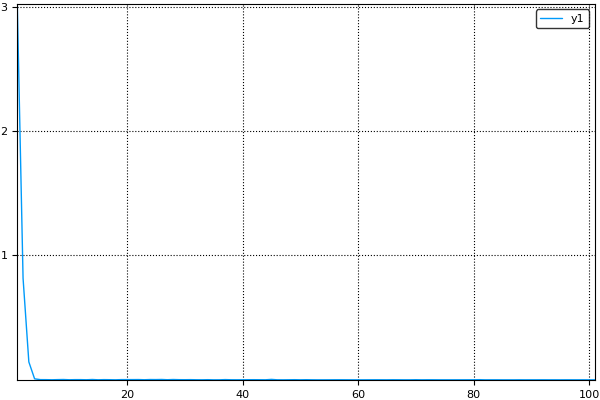

In [602]:
params = copy(start_params)
net = Nets.Net(Nets.Params(widths, params), x_to_u, v_to_y)

train_loss = sensitive_loss(0.5)
validate_loss = train_loss
losses = [mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled)]

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

@showprogress for i in 1:nepoch
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.1 * 0.99^i, batch_size=1))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses)

In [603]:
validate_loss(params, train_data_scaled[1][1], train_data_scaled[1][2])

0.000248214918906658

In [604]:
test_data[1]

([-0.0187653, -0.718525], [0.243945 2.0 1.0; -5.89286 1.0 4.0])

In [605]:
net(test_data[1][1])

2-element Array{Float64,1}:
  0.413014
 -5.65526 

In [606]:
train_data_scaled[1]

([0.418986, 0.176851], [0.639134 1.0 0.415506; 0.0381642 0.300838 1.0])

In [607]:
net.params.weights

1-element Array{Base.ReshapedArray{Float64,2,SubArray{Float64,1,Array{Float64,1},Tuple{UnitRange{Int64}},true},Tuple{}},1}:
 [0.994001 0.401; 0.286705 0.985309]

In [608]:
ForwardDiff.jacobian(vu, [0., 0])

2×2 Array{Float64,2}:
 1.0       0.415506
 0.300838  1.0     

In [609]:
mean([sum(abs2, net(xy[1]) .- xy[2][:, 1]) for xy in test_data])

0.07156635774992463

In [610]:
x = randn(2)
x |> x_to_u |> net |> v_to_y

2-element Array{Float64,1}:
 16.58  
 -3.8019

In [611]:
f(x)

2-element Array{Float64,1}:
 5.16326
 4.36235


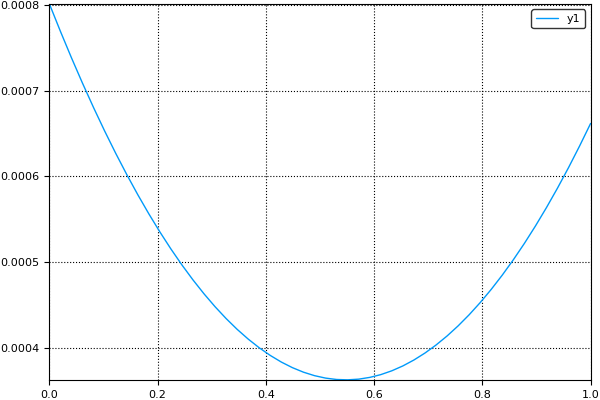

In [612]:
plot(linspace(0, 1), λ -> mean(xy -> sensitive_loss(λ)(params, xy[1], xy[2]), train_data_scaled))

In [613]:
net.params.weights

1-element Array{Base.ReshapedArray{Float64,2,SubArray{Float64,1,Array{Float64,1},Tuple{UnitRange{Int64}},true},Tuple{}},1}:
 [0.994001 0.401; 0.286705 0.985309]

In [614]:
ForwardDiff.jacobian(net, x)

2×2 Array{Float64,2}:
 1.988     0.965089
 0.953023  3.94124 

In [615]:
ForwardDiff.jacobian(vu, x)

2×2 Array{Float64,2}:
 1.0       0.415506
 0.300838  1.0     

In [616]:
reload("Nets")

In [627]:
f(x) = [sin(2 * x[1])]

X = [[x] for x in linspace(-pi, pi, 60)]
Y = [hcat(f(x), ForwardDiff.jacobian(f, x)) for x in X];

data = collect(zip(X, Y))
train_data, test_data = splitobs(shuffleobs(data), 1/6);

train_data_scaled, x_to_u, v_to_y = Nets.rescale(train_data)
for (x, yJ) in train_data
    y = yJ[:, 1]
    J = yJ[:, 2:end]
    @assert y ≈ f(x)
    @assert J ≈ ForwardDiff.jacobian(f, x)
end

u_to_x = inv(x_to_u)
y_to_v = inv(v_to_y)

for (u, vJ) in train_data_scaled
    v = vJ[:, 1]
    J = vJ[:, 2:end]
    @assert v |> v_to_y ≈ u |> u_to_x |> f
    @assert J ≈ ForwardDiff.jacobian(u -> u |> u_to_x |> f |> y_to_v, u)
    @assert maximum(abs, J) <= 1.0
    
end

In [634]:
widths = [1, 16, 16, 16, 16, 1]

function sensitive_loss(λ)
    q = [1.0-λ λ]
    (params, x, y) -> sum(abs2, q .* (Nets.predict_sensitivity(Nets.Net(Nets.Params(widths, params)), x) .- y))
end

sensitive_loss (generic function with 1 method)

In [649]:
start_params = 0.1 * randn(Nets.Params{Float64}, widths).data
nepoch = 1000;

mean((xy->begin  # In[636], line 8:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.5439757742124055


Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:00

mean((xy->begin  # In[636], line 15:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.45994767351761306


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04



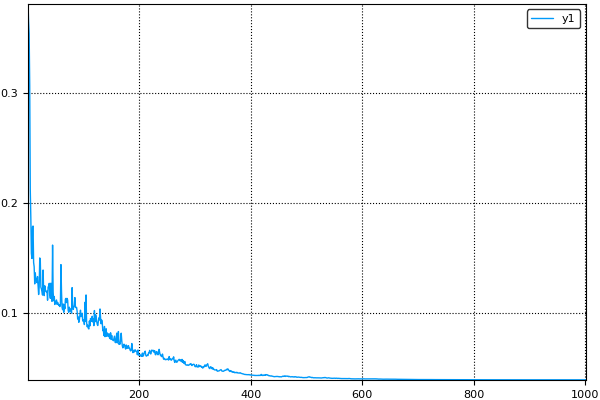

In [636]:
params = copy(start_params)
net = Nets.Net(Nets.Params(widths, params), x_to_u, v_to_y)

train_loss = sensitive_loss(0.0)
validate_loss = train_loss
losses = [mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled)]

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

@showprogress for i in 1:nepoch
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.01 * 0.99^i, batch_size=2))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses)


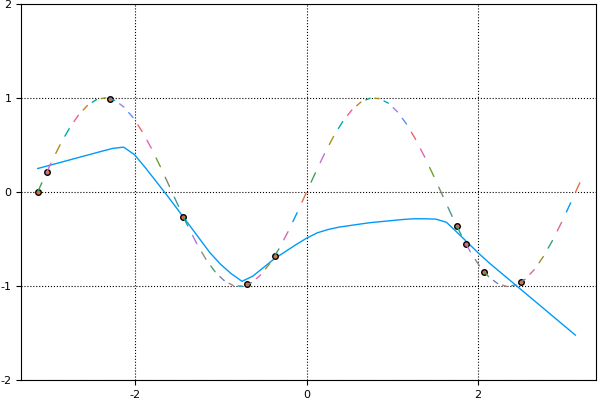

In [637]:
plt = plot(linspace(-pi, pi, 51), x -> net([x])[1], legend=nothing, ylim=(-2, 2))
plot!(plt, [x[1] for (x, y) in train_data], [y[1] for (x, y) in train_data], line=nothing, marker=:circle)
for (x, y) in zip(X, Y)
    eps = 5e-2
    plot!(plt, [x[1], x[1] + eps], [y[1], y[1] + eps * y[2]])
end
plt

mean((xy->begin  # In[652], line 8:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.49418648421197986


Progress:  96%|████████████████████████████████████████ |  ETA: 0:00:00

mean((xy->begin  # In[652], line 15:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.24544921364700897


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03



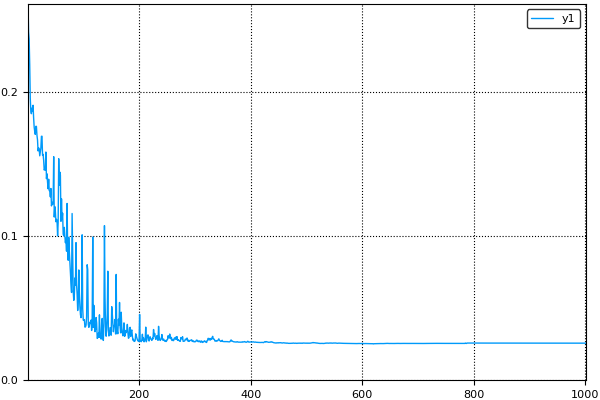

In [652]:
params = copy(start_params)
net = Nets.Net(Nets.Params(widths, params), x_to_u, v_to_y)

train_loss = sensitive_loss(0.5)
validate_loss = train_loss
losses = [mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled)]

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

@showprogress for i in 1:nepoch
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.01 * 0.99^i, batch_size=2))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses, ylim=(0, losses[1]))


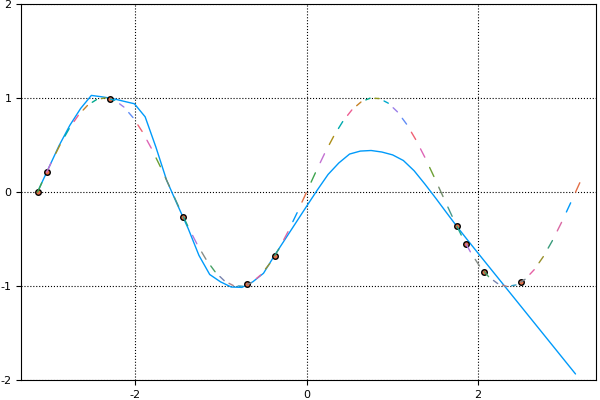

In [653]:
plt = plot(linspace(-pi, pi, 51), x -> net([x])[1], legend=nothing, ylim=(-2, 2))
plot!(plt, [x[1] for (x, y) in train_data], [y[1] for (x, y) in train_data], line=nothing, marker=:circle)
for (x, y) in zip(X, Y)
    eps = 5e-2
    plot!(plt, [x[1], x[1] + eps], [y[1], y[1] + eps * y[2]])
end
plt

In [654]:
mean(xy -> sensitive_loss(1.0)(params, xy[1], xy[2]), train_data_scaled)

0.09331627933156893